MARKOV ICL - MATRIX TREE THEOREM (K matrix formulation)
K=75, D=8, N=6, B=2, nodes=15
Device: cpu

Creating GMM...
Generating data...

Creating model...
  Initialized Matrix Tree method (rate matrix K formulation)
  Parameters: 12,915

Training...
Epoch  10 | Train: 0.1486 | Val: 0.1519
Epoch  20 | Train: 0.0975 | Val: 0.1064
Epoch  30 | Train: 0.0709 | Val: 0.0821
Epoch  40 | Train: 0.0561 | Val: 0.0693
Epoch  50 | Train: 0.0460 | Val: 0.0609
Epoch  60 | Train: 0.0388 | Val: 0.0547
Epoch  70 | Train: 0.0330 | Val: 0.0491
Epoch  80 | Train: 0.0282 | Val: 0.0448
Epoch  90 | Train: 0.0240 | Val: 0.0399
Epoch 100 | Train: 0.0205 | Val: 0.0356
Epoch 110 | Train: 0.0175 | Val: 0.0318
Epoch 120 | Train: 0.0149 | Val: 0.0282
Epoch 130 | Train: 0.0128 | Val: 0.0252
Epoch 140 | Train: 0.0109 | Val: 0.0224
Epoch 150 | Train: 0.0092 | Val: 0.0198
Epoch 160 | Train: 0.0078 | Val: 0.0173
Epoch 170 | Train: 0.0067 | Val: 0.0153
Epoch 180 | Train: 0.0058 | Val: 0.0133
Epoch 190 | Train: 0.0050 | Val:

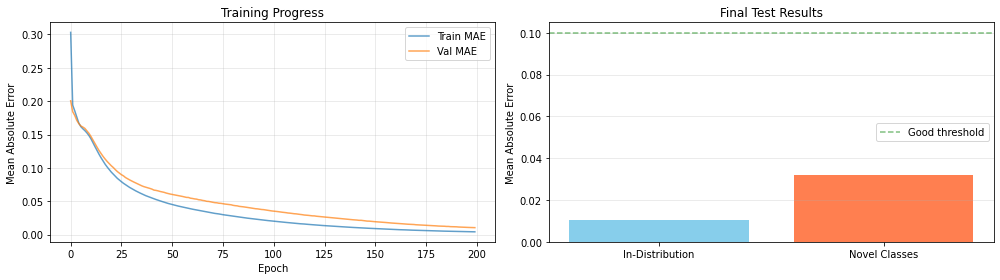

In [2]:
# Import necessary components
import torch
import numpy as np
from markov_icl_gmm_matrix_tree import (
    GaussianMixtureModel, 
    generate_icl_gmm_data, 
    ICLGMMDataset,
    collate_fn,
    MatrixTreeMarkovICL,
    train_model,
    test_icl
)
from torch.utils.data import DataLoader
import os
import time

# Set parameters
params = {
    'K': 75,              # Number of GMM classes
    'D': 8,               # Dimension
    'N': 6,               # Context examples
    'B': 2,               # Burstiness
    'n_nodes': 15,        # Markov nodes
    'epochs': 200,        # Training epochs
    'lr': 0.001,          # Learning rate
    'batch_size': 64,
    'train_samples': 10000,
    'val_samples': 2000,
    'epsilon': 0.1,       # Within-class noise
    'seed': 42,
    'exact_copy': True,    # Query is exact copy of context item
    'method': 'direct_solve'
}

print("="*70)
print("MARKOV ICL - MATRIX TREE THEOREM (K matrix formulation)")
print("="*70)
print(f"K={params['K']}, D={params['D']}, N={params['N']}, B={params['B']}, nodes={params['n_nodes']}")
print("="*70)

# Set random seeds
torch.manual_seed(params['seed'])
np.random.seed(params['seed'])

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

# Create GMM
print("Creating GMM...")
gmm = GaussianMixtureModel(K=params['K'], D=params['D'], epsilon=params['epsilon'], seed=params['seed'])

# Generate data
print("Generating data...")
train_data = generate_icl_gmm_data(gmm, params['train_samples'], params['N'], 
                                   novel_classes=False, exact_copy=params['exact_copy'], B=params['B'])
val_data = generate_icl_gmm_data(gmm, params['val_samples'], params['N'], 
                                 novel_classes=False, exact_copy=params['exact_copy'], B=params['B'])

train_loader = DataLoader(ICLGMMDataset(train_data), batch_size=params['batch_size'],
                          shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(ICLGMMDataset(val_data), batch_size=params['batch_size'],
                       collate_fn=collate_fn)

# Create model
print("\nCreating model...")
model = MatrixTreeMarkovICL(n_nodes=params['n_nodes'], z_dim=params['D'], n_labels=1, N=params['N'])

# Train
start_time = time.time()
print("\nTraining...")
print("="*70)
history = train_model(model, train_loader, val_loader, device, 
                     n_epochs=params['epochs'], lr=params['lr'], method=params['method'])
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Test
results = test_icl(model, gmm, params['N'], device, n_samples=1000, 
                  exact_copy=params['exact_copy'], B=params['B'], method=params['method'])

# Save model
os.makedirs('results', exist_ok=True)
model_path = f'results/markov_icl_gmm_K{params["K"]}_N{params["N"]}_mtree.pt'
torch.save(model.state_dict(), model_path)
print(f"\n✓ Saved: {model_path}")

# You can also plot the training history
try:
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    
    ax1.plot(history['train_mae'], label='Train MAE', alpha=0.7)
    ax1.plot(history['val_mae'], label='Val MAE', alpha=0.7)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Mean Absolute Error')
    ax1.set_title('Training Progress')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Bar chart of final results
    ax2.bar(['In-Distribution', 'Novel Classes'], 
            [results['in_dist'], results['novel_classes']],
            color=['skyblue', 'coral'])
    ax2.set_ylabel('Mean Absolute Error')
    ax2.set_title('Final Test Results')
    ax2.axhline(y=0.1, color='g', linestyle='--', label='Good threshold', alpha=0.5)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("\n(Install matplotlib to see training plots)")

MARKOV ICL - CLASSIFICATION (Softmax Output)
K=75, D=8, N=6, B=2, nodes=5
Method: direct_solve, Temperature: 1.0
Device: cpu

Creating GMM with discrete labels...
  Class labels: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]... (1 to 75)

Generating data...

Creating model...
  Initialized ICL Attention model (K=75 classes, attention over 6 context items)
  Label modulation: False
  Parameters: 1,455

Training...
Epoch  10 | Train: 72.33% | Val: 73.25%
Epoch  20 | Train: 87.98% | Val: 88.90%
Epoch  30 | Train: 95.91% | Val: 95.35%
Epoch  40 | Train: 98.00% | Val: 97.20%
Epoch  50 | Train: 98.75% | Val: 98.25%
Epoch  60 | Train: 99.20% | Val: 98.30%
Epoch  70 | Train: 99.47% | Val: 98.40%
Epoch  80 | Train: 99.68% | Val: 98.35%
Epoch  90 | Train: 99.84% | Val: 98.65%
Epoch 100 | Train: 99.88% | Val: 98.70%
Training time: 12.86 seconds

TESTING IN-CONTEXT LEARNING (CLASSIFICATION)

1. In-Distribution Test (classes 1 to 75):
   Accuracy: 98.50% (985/1000)

2. Out-of-Distribution Test (novel m

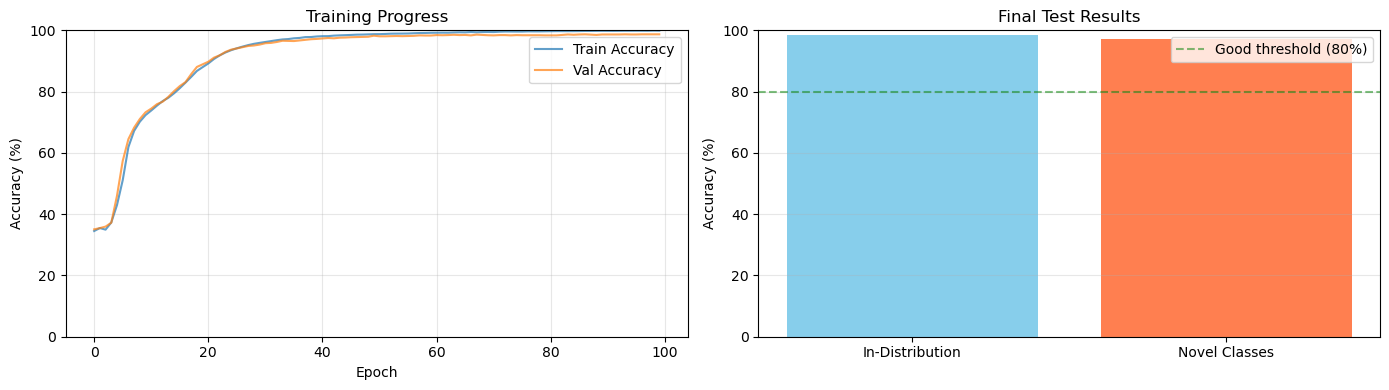

In [1]:
### discrete test

# Import necessary components
import torch
import numpy as np
# NEW (classification version)
from markov_icl_gmm_discrete_linear import (
    GaussianMixtureModel, 
    generate_icl_gmm_data, 
    ICLGMMDataset,
    collate_fn,
    MatrixTreeMarkovICL,
    train_model,
    test_icl
)
from torch.utils.data import DataLoader
import os
import time

# Set parameters
params = {
    'K': 75,              # Number of GMM classes
    'K_classes': 75,      # Number of output classes (can be different from K)
    'D': 8,               # Dimension
    'N': 6,               # Context examples
    'B': 2,               # Burstiness
    'n_nodes': 5,        # Markov nodes
    'epochs': 100,        # Training epochs
    'lr': 0.001,          # Learning rate
    'batch_size': 64,
    'train_samples': 10000,
    'val_samples': 2000,
    'epsilon': 0.1,       # Within-class noise
    'seed': 42,
    'exact_copy': True,   # Query is exact copy of context item
    'method': 'direct_solve',
    'temperature': 1.0    # Softmax temperature
}

print("="*70)
print("MARKOV ICL - CLASSIFICATION (Softmax Output)")
print("="*70)
print(f"K={params['K']}, D={params['D']}, N={params['N']}, B={params['B']}, nodes={params['n_nodes']}")
print(f"Method: {params['method']}, Temperature: {params['temperature']}")
print("="*70)

# Set random seeds
torch.manual_seed(params['seed'])
np.random.seed(params['seed'])

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

# Create GMM with discrete labels (1 to K)
print("Creating GMM with discrete labels...")
gmm = GaussianMixtureModel(K=params['K'], D=params['D'], epsilon=params['epsilon'], seed=params['seed'])
print(f"  Class labels: {gmm.class_to_label[:min(10, params['K'])].numpy()}... (1 to {params['K']})")

# Generate data
print("\nGenerating data...")
train_data = generate_icl_gmm_data(gmm, params['train_samples'], params['N'], 
                                   novel_classes=False, exact_copy=params['exact_copy'], 
                                   B=params['B'], K_classes=params['K_classes'])
val_data = generate_icl_gmm_data(gmm, params['val_samples'], params['N'], 
                                 novel_classes=False, exact_copy=params['exact_copy'], 
                                 B=params['B'], K_classes=params['K_classes'])

train_loader = DataLoader(ICLGMMDataset(train_data), batch_size=params['batch_size'],
                          shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(ICLGMMDataset(val_data), batch_size=params['batch_size'],
                       collate_fn=collate_fn)

# Create model
print("\nCreating model...")
model = MatrixTreeMarkovICL(n_nodes=params['n_nodes'], z_dim=params['D'], 
                           K_classes=params['K_classes'], N=params['N'])

# Train
start_time = time.time()
print("\nTraining...")
print("="*70)
history = train_model(model, train_loader, val_loader, device, 
                     n_epochs=params['epochs'], lr=params['lr'], 
                     method=params['method'], temperature=params['temperature'])
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Test
results = test_icl(model, gmm, params['N'], device, n_samples=1000, 
                  exact_copy=params['exact_copy'], B=params['B'], 
                  method=params['method'], K_classes=params['K_classes'],
                  temperature=params['temperature'])

# Save model
os.makedirs('results', exist_ok=True)
model_path = f'results/markov_icl_gmm_K{params["K"]}_N{params["N"]}_classification_T{params["temperature"]:.1f}.pt'
torch.save(model.state_dict(), model_path)
print(f"\n✓ Saved: {model_path}")

# Plot training history
try:
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    
    # Training progress (accuracy instead of MAE)
    ax1.plot(history['train_acc'], label='Train Accuracy', alpha=0.7)
    ax1.plot(history['val_acc'], label='Val Accuracy', alpha=0.7)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Training Progress')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 100])
    
    # Bar chart of final results (accuracy)
    ax2.bar(['In-Distribution', 'Novel Classes'], 
            [results['in_dist'], results['novel_classes']],
            color=['skyblue', 'coral'])
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Final Test Results')
    ax2.axhline(y=80, color='g', linestyle='--', label='Good threshold (80%)', alpha=0.5)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim([0, 100])
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("\n(Install matplotlib to see training plots)")